In [1]:
import torch
import torch.nn as nn

In [2]:
class Generator(nn.Module):
    def __init__(self,z_dim=20,image_size=64):
        super(Generator, self).__init__()
        
        self.layer1=nn.Sequential(nn.ConvTranspose2d(z_dim,image_size*8,kernel_size=4,stride=1),
                                 nn.BatchNorm2d(image_size*8),
                                 nn.ReLU(inplace=True))
        self.layer2=nn.Sequential(nn.ConvTranspose2d(image_size*8,image_size*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(image_size*4),
                                 nn.ReLU(inplace=True))
        self.layer3=nn.Sequential(nn.ConvTranspose2d(image_size*4,image_size*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(image_size*2),
                                 nn.ReLU(inplace=True))
        self.layer4=nn.Sequential(nn.ConvTranspose2d(image_size*2,image_size,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(image_size),
                                 nn.ReLU(inplace=True))
        
        self.last=nn.Sequential(nn.ConvTranspose2d(image_size,1,kernel_size=4,stride=2,padding=1),
                               nn.Tanh())
        #注意：白黒画像なので出力チャネルは1つ
        
    def forward(self,z):
        out=self.layer1(z)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.last(out)
        
        return out

torch.Size([1, 1, 64, 64])


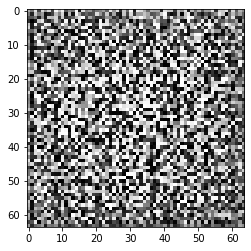

In [3]:
#動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G=Generator(z_dim=20,image_size=64)

#入力する乱数
input_z=torch.randn(1,20)

#テンソルサイズを(1,20,1,1)に変形
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)

#偽画像を出力
fake_images=G(input_z)
print(fake_images.size())

img_transformed=fake_images[0][0].detach().numpy()
plt.imshow(img_transformed,'gray')
plt.show()

In [4]:
class Discriminator(nn.Module):
    
    def __init__(self,z_dim=20,image_size=64):
        super(Discriminator,self).__init__()
        
        self.layer1=nn.Sequential(nn.Conv2d(1,image_size,kernel_size=4,stride=2,padding=1),
                                 nn.LeakyReLU(0.1,inplace=True))
        #注意：白黒画像なので入力チャネルは1
        
        self.layer2=nn.Sequential(nn.Conv2d(image_size,image_size*2,kernel_size=4,stride=2,padding=1),
                                 nn.LeakyReLU(0.1,inplace=True))
        
        self.layer3=nn.Sequential(nn.Conv2d(image_size*2,image_size*4,kernel_size=4,stride=2,padding=1),
                                 nn.LeakyReLU(0.1,inplace=True))
        
        self.layer4=nn.Sequential(nn.Conv2d(image_size*4,image_size*8,kernel_size=4,stride=2,padding=1),
                                 nn.LeakyReLU(0.1,inplace=True))
        
        self.last=nn.Conv2d(image_size*8,1,kernel_size=4,stride=1)
        
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.last(out)
        
        return out

In [5]:
#動作確認
D=Discriminator(z_dim=20,image_size=64)

#偽画像生成
input_z=torch.randn(1,20)
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
fake_images=G(input_z)

#偽画像をDに入力
d_out=D(fake_images)

#出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[[[0.4978]]]], grad_fn=<SigmoidBackward>)


In [6]:
#Dの誤差関数のイメージ実装
#maximize log(D(x))+log(1-D(G(z)))

# xが未定義なので動作はエラーになる

#正解ラベルを作成
mini_batch_size=2
label_real=torch.full((mini_batch_size,),1)

#偽ラベルを作成
label_fake=torch.full((mini_batch_size,),0)

#誤差関数を定義
criterion=nn.BCEWithLogitsLoss(reduction='mean')

#真の画像を判定
d_out_real=D(x)

#偽の画像を生成して判定
input_z=torch.randn(mini_batch_size,20)
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
fake_images=G(input_z)
d_out_fake=D(fake_images)

#誤差を計算
d_loss_real=criterion(d_out_real.view(-1),label_real)
d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
d_loss=d_loss_real+d_loss_fake


#Gの損失関数のイメージ実装
#maximize log(D(G(z)))

#xが未定義なのでエラーになる

#偽の画像を生成して判定
input_z=torch.randn(mini_batch_size,20)
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
fake_images=G(input_z)
d_out_fake=D(fake_images)

#誤差を計算
g_loss=criterion(d_out_fake.view(-1),label_real)

NameError: name 'x' is not defined

In [7]:
from torchvision import transforms
from torch.utils import data
from PIL import Image

In [8]:
def make_datapath_list():
    #学習，検証の画像データとアノテーションデータへのファイルパスリスト作成する
    
    train_img_list=list()
    
    for img_idx in range(200):
        img_path="./data/img_78/img_7_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path="./data/img_78/img_8_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform():
    #画像前処理クラス
    
    def __init__(self,mean,std):
        self.data_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
        
    def __call__(self,img):
        return self.data_transform(img)
    
class GAN_IMG_Dataset(data.Dataset):
    #画像のDatasetクラス．PytorchのDatasetクラスを継承
    
    def __init__(self,file_list,transform):
        self.file_list=file_list
        self.transform=transform
        
    def __len__(self):
        #画像の枚数を返す
        return len(self.file_list)
    
    def __getitem__(self,index):
        #前処理した画像のTensor形式のデータを取得
        
        img_path=self.file_list[index]
        img=Image.open(img_path) #[高さ][幅]
        
        #画像の前処理
        img_transformed = self.transform(img)
        
        return img_transformed
    
#Datasetの作成と確認
#ファイルリストを作成
train_img_list=make_datapath_list()

#Datasetを作成
mean=(0.5,)
std=(0.5,)
train_dataset=GAN_IMG_Dataset(file_list=train_img_list,transform=ImageTransform(mean,std))

#DataLoaderを作成
batch_size=64

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

#動作確認
batch_iterator=iter(train_dataloader)
imges=next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


In [9]:
#ネットワークの初期化
def weights_init(m):
    classname=m.__class__.__name__
    print(m)
    print('----------------')
    if classname.find('Conv') != -1:
        #Conv2d,ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data,0.0,0.02)
        nn.init.constant_(m.bias.data,0)
    elif classname.find('BatchNorm') != -1:
        #BatchNorm2dの初期化
        nn.init.normal_(m.weight.data,1,0.02)
        nn.init.constant_(m.bias.data,0)
        
#初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print('ネットワークの初期化完了')

ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))
----------------
BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------------
ReLU(inplace=True)
----------------
Sequential(
  (0): ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
----------------
ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
----------------
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------------
ReLU(inplace=True)
----------------
Sequential(
  (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
----------------
ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
----------------
BatchNorm2d(128, eps=1e-05

In [10]:
import time
#モデルを学習させる関数

def train_model(G,D,dataloader,num_epochs):
    
    #GPUが使えるか確認
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用するデバイス：",device)
    
    #最適化手法の設定
    g_lr,d_lr=0.0001,0.0004
    beta1,beta2=0.0,0.9
    g_optimizer=torch.optim.Adam(G.parameters(),g_lr,[beta1,beta2])
    d_optimizer=torch.optim.Adam(D.parameters(),d_lr,[beta1,beta2])
    
    #誤差関数を定義
    criterion=nn.BCEWithLogitsLoss(reduction='mean')
    
    #パラメータをハードコーディング
    z_dim=20
    mini_batch=64
    
    #ネットワークをGPUへ
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark=True
    
    #画像の枚数
    num_train_imgs=len(dataloader.dataset)
    batch_size=dataloader.batch_size
    
    #イテレーションカウンタをセット
    iteration=1
    losg=[]
    
    #epoch-loop
    for epoch in range(num_epochs):
        
        #開始時刻を保存
        t_epoch_start=time.time()
        epoch_g_loss=0.0
        epoch_d_loss=0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch,num_epochs))
        print('-------------')
        print('(train)')
        
        #データローダからminibatchずつ取り出すループ
        for imges in dataloader:
            #
            #1. Discriminatorの学習
            #
            
            #mini-batch-sizeが1だとバッチノーマライゼーションでエラーになるので避ける
            if imges.size()[0] == 1:
                continue
                
            #GPUが使えるならGPUにデータを送る
            imges=imges.to(device)
            
            #正解ラベルと偽ラベルを作成
            #epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size=imges.size()[0]
            label_real=torch.full((mini_batch_size,),1).to(device)
            label_fake=torch.full((mini_batch_size,),0).to(device)
            
            #真の画像を判定
            d_out_real=D(imges)
            
            #偽の画像を生成して判定
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images=G(input_z)
            d_out_fake=D(fake_images)
            
            #誤差を計算
            d_loss_real=criterion(d_out_real.view(-1),label_real)
            d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
            d_loss=d_loss_real+d_loss_fake
            
            #back-prop
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            #
            #2. Generatorの学習
            #
            #偽の画像を生成して判定
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images=G(input_z)
            d_out_fake=D(fake_images)
            
            #誤差を計算
            g_loss=criterion(d_out_fake.view(-1),label_real)
            
            #back-prop
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            #
            #3. 記録
            #
            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            iteration+=1
            
        #epochのphaseごとの正解率
        t_epoch_finishi=time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss::{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch,epoch_d_loss/batch_size,epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finishi-t_epoch_start))
        t_epoch_start=time.time()
        
    return G,D

In [11]:
#学習・検証
num_epochs=200
G_update,D_update=train_model(G,D,dataloader=train_dataloader,num_epochs=num_epochs)

使用するデバイス： cuda:0
-------------
Epoch 0/200
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss::0.1060 ||Epoch_G_Loss:0.0841
timer: 1.0768 sec.
-------------
Epoch 1/200
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss::0.0424 ||Epoch_G_Loss:0.3124
timer: 0.5825 sec.
-------------
Epoch 2/200
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss::0.2529 ||Epoch_G_Loss:0.4633
timer: 0.5722 sec.
-------------
Epoch 3/200
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss::0.0327 ||Epoch_G_Loss:0.2111
timer: 0.5965 sec.
-------------
Epoch 4/200
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss::0.0063 ||Epoch_G_Loss:0.4069
timer: 0.5761 sec.
-------------
Epoch 5/200
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss::0.1097 ||Epoch_G_Loss:0.3900
timer: 0.6047 sec.
-------------
Epoch 6/200
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss::0.0033 ||Epoch_G_Loss:0.4575
timer: 0.6074 sec.
-------------
Epoch 7/200
------------

-------------
epoch 60 || Epoch_D_Loss::0.0939 ||Epoch_G_Loss:0.1874
timer: 0.5275 sec.
-------------
Epoch 61/200
-------------
(train)
-------------
epoch 61 || Epoch_D_Loss::0.0929 ||Epoch_G_Loss:0.1686
timer: 0.5144 sec.
-------------
Epoch 62/200
-------------
(train)
-------------
epoch 62 || Epoch_D_Loss::0.0929 ||Epoch_G_Loss:0.1933
timer: 0.5073 sec.
-------------
Epoch 63/200
-------------
(train)
-------------
epoch 63 || Epoch_D_Loss::0.0928 ||Epoch_G_Loss:0.1723
timer: 0.5228 sec.
-------------
Epoch 64/200
-------------
(train)
-------------
epoch 64 || Epoch_D_Loss::0.1006 ||Epoch_G_Loss:0.1914
timer: 0.5238 sec.
-------------
Epoch 65/200
-------------
(train)
-------------
epoch 65 || Epoch_D_Loss::0.0742 ||Epoch_G_Loss:0.1764
timer: 0.5322 sec.
-------------
Epoch 66/200
-------------
(train)
-------------
epoch 66 || Epoch_D_Loss::0.0958 ||Epoch_G_Loss:0.2137
timer: 0.5674 sec.
-------------
Epoch 67/200
-------------
(train)
-------------
epoch 67 || Epoch_D_Loss::0

-------------
epoch 120 || Epoch_D_Loss::0.0593 ||Epoch_G_Loss:0.2625
timer: 0.6140 sec.
-------------
Epoch 121/200
-------------
(train)
-------------
epoch 121 || Epoch_D_Loss::0.0626 ||Epoch_G_Loss:0.2787
timer: 0.5568 sec.
-------------
Epoch 122/200
-------------
(train)
-------------
epoch 122 || Epoch_D_Loss::0.0816 ||Epoch_G_Loss:0.2662
timer: 0.5504 sec.
-------------
Epoch 123/200
-------------
(train)
-------------
epoch 123 || Epoch_D_Loss::0.0718 ||Epoch_G_Loss:0.2503
timer: 0.6017 sec.
-------------
Epoch 124/200
-------------
(train)
-------------
epoch 124 || Epoch_D_Loss::0.0645 ||Epoch_G_Loss:0.2422
timer: 0.5640 sec.
-------------
Epoch 125/200
-------------
(train)
-------------
epoch 125 || Epoch_D_Loss::0.0805 ||Epoch_G_Loss:0.2551
timer: 0.5323 sec.
-------------
Epoch 126/200
-------------
(train)
-------------
epoch 126 || Epoch_D_Loss::0.0532 ||Epoch_G_Loss:0.2888
timer: 0.5358 sec.
-------------
Epoch 127/200
-------------
(train)
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss::0.0487 ||Epoch_G_Loss:0.4131
timer: 0.6205 sec.
-------------
Epoch 180/200
-------------
(train)
-------------
epoch 180 || Epoch_D_Loss::0.0334 ||Epoch_G_Loss:0.3696
timer: 0.6130 sec.
-------------
Epoch 181/200
-------------
(train)
-------------
epoch 181 || Epoch_D_Loss::0.0503 ||Epoch_G_Loss:0.4071
timer: 0.5994 sec.
-------------
Epoch 182/200
-------------
(train)
-------------
epoch 182 || Epoch_D_Loss::0.0225 ||Epoch_G_Loss:0.3898
timer: 0.5945 sec.
-------------
Epoch 183/200
-------------
(train)
-------------
epoch 183 || Epoch_D_Loss::0.0695 ||Epoch_G_Loss:0.3637
timer: 0.5610 sec.
-------------
Epoch 184/200
-------------
(train)
-------------
epoch 184 || Epoch_D_Loss::0.0255 ||Epoch_G_Loss:0.4408
timer: 0.5475 sec.
-------------
Epoch 185/200
-------------
(train)
-------------
epoch 185 || Epoch_D_Loss::0.0287 ||Epoch_G_Loss:0.4951
timer: 0.5324 sec.
-------------
Epoch 186/200
-------------
(train)
-------------
epoch 186 || 

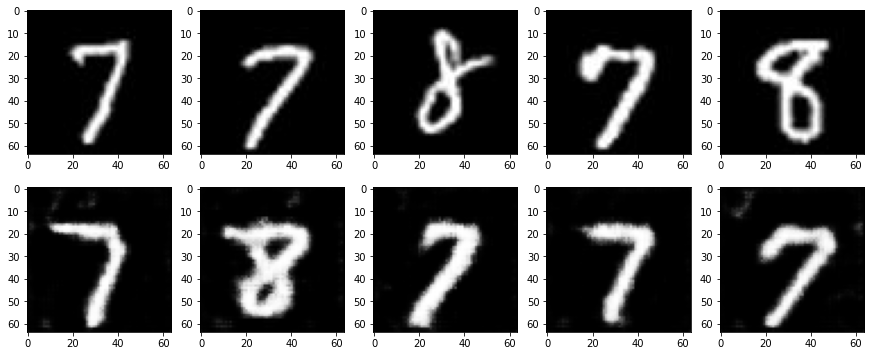

In [19]:
#生成データと訓練データを可視化
#本セルはいい感じの画像が生成されるまで，何度も実行し直すと良い

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#入力となる乱数生成
batch_size=8
z_dim=20
fixed_z=torch.randn(batch_size,z_dim)
fixed_z=fixed_z.view(fixed_z.size(0),fixed_z.size(1),1,1)

#画像生成
fake_images=G_update(fixed_z.to(device))

#訓練データ
batch_iterator=iter(train_dataloader)
imges=next(batch_iterator)

#出力
fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    #上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),'gray')
    
    #下段に生成データを表示する
    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),'gray')